In [48]:
from imutils import paths
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
from skimage.feature import hog
from skimage import data, exposure
from skimage.feature import graycomatrix
from skimage.feature import graycoprops

In [25]:
train_dataset_path = "/Users/harysetiawan/Documents/College Project/PCD/FinalProject/dataset/train"
test_dataset_path = "/Users/harysetiawan/Documents/College Project/PCD/FinalProject/dataset/test"

train_dataset_list = list(paths.list_images(train_dataset_path))
test_dataset_list = list(paths.list_images(test_dataset_path))

/Users/harysetiawan/Documents/College Project/PCD/FinalProject/venv/lib/python3.9/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')


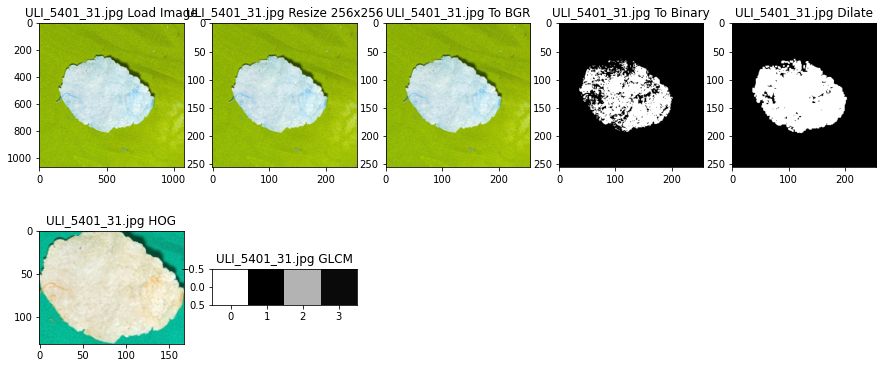

In [43]:
columns = 5
rows = 3
plt.figure(figsize=(15,10))

extracted_shape = []
img_path = train_dataset_list[25]

title = img_path.split("/")[10] 

i = 1

img = cv2.imread(img_path,flags=cv2.IMREAD_COLOR)
plt.subplot(rows, columns, i)
plt.title("{} Load Image".format(title))
plt.imshow(img)

i+=1
resolution = 256
img = cv2.resize(img,(resolution,resolution),interpolation=cv2.INTER_AREA)
plt.subplot(rows, columns, i)
plt.title("{} Resize {}x{}".format(title,resolution,resolution))
plt.imshow(img)

i+=1
img_rgb = cv2.cvtColor(img,code=cv2.COLOR_BGR2RGB)
plt.subplot(rows, columns, i)
plt.title("{} To BGR".format(title))
plt.imshow(img)

i+=1
img = cv2.cvtColor(img_rgb,code=cv2.COLOR_RGB2GRAY)
plt.subplot(rows, columns, i)
plt.title("{} To Gray".format(title))
plt.imshow(img,cmap='gray')


tresh, img = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
plt.subplot(rows, columns, i)
plt.title("{} To Binary".format(title))
plt.imshow(img,cmap='gray')

i+=1
kernal = np.ones((2, 2), np.uint8)
dilation = cv2.dilate(img, kernal, iterations=2)
plt.subplot(rows, columns, i)
plt.title("{} Dilate".format(title))
plt.imshow(dilation,cmap='gray')


i+=1
contours = cv2.findContours(
    dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = contours[0] if len(contours) == 2 else contours[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    ROI = img_rgb[y:y+h, x:x+w]
    break
plt.subplot(rows, columns, i)
plt.title("{} HOG".format(title))
plt.imshow(ROI,cmap='gray')

img = cv2.cvtColor(ROI,cv2.COLOR_RGB2GRAY)

i+=1
GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4],levels=255, symmetric=False, normed=True)
#list(GLCM[:,:,0,2])


#Calculate texture statistics
contrast = graycoprops(GLCM, 'contrast')
dissimilarity = graycoprops(GLCM, 'dissimilarity')
homogeneity = graycoprops(GLCM, 'homogeneity')
energy = graycoprops(GLCM, 'energy')
correlation = graycoprops(GLCM, 'correlation')
ASM = graycoprops(GLCM, 'ASM')

GLCM_feature = contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0],ASM[0][0]

plt.subplot(rows, columns, i)
plt.title("{} GLCM".format(title))
plt.imshow(ASM,cmap='gray')


In [44]:
def extract_roi(image_path,resolution = 256):
    img = cv2.imread(image_path,flags=cv2.IMREAD_COLOR)
    img = cv2.resize(img,(resolution,resolution),interpolation=cv2.INTER_AREA)
    img_rgb = cv2.cvtColor(img,code=cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img_rgb,code=cv2.COLOR_RGB2GRAY)
    tresh, img = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
    kernal = np.ones((2, 2), np.uint8)
    dilation = cv2.dilate(img, kernal, iterations=2)
    contours = cv2.findContours(
        dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = contours[0] if len(contours) == 2 else contours[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        ROI = img_rgb[y:y+h, x:x+w]
        break
    ROI = cv2.resize(ROI,(resolution,resolution),interpolation=cv2.INTER_AREA)
    return ROI

(<matplotlib.image.AxesImage at 0x461ced310>, (256, 256, 3), numpy.ndarray)

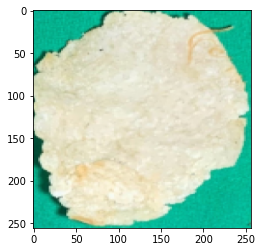

In [45]:
img = extract_roi(image_path="/Users/harysetiawan/Documents/College Project/PCD/FinalProject/Images/train/ULI/ULI_5401.jpg")
plt.imshow(img),img.shape,type(img)

In [54]:
plt.figure(figsize=(15,7))
columns = 5
rows = 3

def extract_feature(image_list):
    extracted_shape = []
    for i,img_path in enumerate(image_list):
        title = img_path.split("/")[10]

        img = extract_roi(image_path=img_path)
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        _,hog_image = hog(img,orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
        img_hog_array = hog_image.reshape((1,hog_image.shape[0]*hog_image.shape[1]))[0]
        GLCM = graycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4],levels=255, symmetric=False, normed=True)


        #Calculate texture statistics
        GLCM_feature = []
        contrast = graycoprops(GLCM, 'contrast')
        GLCM_feature.append(contrast[0][0])
        dissimilarity = graycoprops(GLCM, 'dissimilarity')
        GLCM_feature.append(dissimilarity[0][0])
        homogeneity = graycoprops(GLCM, 'homogeneity')
        GLCM_feature.append(homogeneity[0][0])
        energy = graycoprops(GLCM, 'energy')
        GLCM_feature.append(energy[0][0])
        correlation = graycoprops(GLCM, 'correlation')
        GLCM_feature.append(correlation[0][0])
        ASM = graycoprops(GLCM, 'ASM')
        GLCM_feature.append(ASM[0][0])
        # print(type(GLCM_feature),GLCM_feature)
        hog_glcm = np.append(GLCM_feature,img_hog_array)
        extracted_shape.append(np.append([title.split("_")[0]],hog_glcm))
        ## Show Image
        # plt.subplot(rows, columns, i+1)
        # plt.axis(False)
        # plt.grid(True)
        # plt.title(title)
        # plt.imshow(hog_image,cmap='gray')
    return extracted_shape

train_dasets = extract_feature(train_dataset_list)
test_dasets = extract_feature(test_dataset_list)


<Figure size 1080x504 with 0 Axes>

In [55]:
train_dasets = pd.DataFrame(train_dasets)
test_dasets = pd.DataFrame(test_dasets)

In [56]:
train_dasets.head(5)

,0,1,2,3,4,5,6,7,8,9,...,65533,65534,65535,65536,65537,65538,65539,65540,65541,65542
0,ULI,60.0451746323537,3.4448069852941545,0.3652549819224547,0.04613359226676191,0.9897262173038064,0.0021283083354358347,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ULI,1.6081495098039216,0.3648897058823529,0.8966007553227262,0.2060570900876515,0.9790555146249391,0.04245952437539053,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ULI,1.2645067401960781,0.31769301470588246,0.9061002924769792,0.2032258918893487,0.9791177268316305,0.04130076313422124,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ULI,62.5909466911777,3.4919577205882883,0.3647708679498586,0.04709076638768167,0.9896936086094732,0.0022175402789792096,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ULI,48.36548713235338,2.5196231617647364,0.5842704561182451,0.06866644085651728,0.99112899809492,0.004715080099901586,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
test_dasets.head(5)

,0,1,2,3,4,5,6,7,8,9,...,65533,65534,65535,65536,65537,65538,65539,65540,65541,65542
0,ULI,3.841421568627451,0.7596200980392167,0.8029430309322495,0.153261629749976,0.959839712763055,0.023489127153618734,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ULI,5.979564950980385,1.19626225490196,0.6897087462485105,0.12197683518422239,0.9516271962027145,0.014878348321558953,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ULI,2.651164215686273,0.5510416666666675,0.8523451215163402,0.17519597915386578,0.9673686368277518,0.030693631111681774,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ULI,35.438465073528704,2.2467064950979934,0.5789298312259037,0.07227294014704883,0.9903267351874223,0.005223377877498901,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ULI,38.60165441176421,1.968811274509768,0.6736003580794069,0.0925750576117062,0.9866902163040445,0.008570141291810721,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
train_dasets.to_csv("train_dasets.csv",index=False)
test_dasets.to_csv("test_dasets.csv",index=False)